In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, chi2, RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import time
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB, CategoricalNB

import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0


In [4]:
train.shape

(900, 11)

In [5]:
train.columns

Index(['Patient_ID', 'Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City', 'Deceased'],
      dtype='object')

In [6]:
train.dtypes

Patient_ID                             int64
Family_Case_ID                         int64
Severity                               int64
Name                                  object
Birthday_year                        float64
Parents or siblings infected           int64
Wife/Husband or children infected      int64
Medical_Expenses_Family                int64
Medical_Tent                          object
City                                  object
Deceased                               int64
dtype: object

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         900 non-null    int64  
 1   Family_Case_ID                     900 non-null    int64  
 2   Severity                           900 non-null    int64  
 3   Name                               900 non-null    object 
 4   Birthday_year                      723 non-null    float64
 5   Parents or siblings infected       900 non-null    int64  
 6   Wife/Husband or children infected  900 non-null    int64  
 7   Medical_Expenses_Family            900 non-null    int64  
 8   Medical_Tent                       198 non-null    object 
 9   City                               898 non-null    object 
 10  Deceased                           900 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 77.5+ KB


In [8]:
train.describe()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Deceased
count,900.000000,900.000000,900.000000,723.000000,900.000000,900.000000,900.000000,900.000000
mean,450.500000,14305.827778,2.313333,1990.266943,0.380000,0.521111,895.743333,0.614444
std,259.951919,25418.153900,0.834223,14.523335,0.803247,1.098385,1385.829926,0.486997
min,1.000000,345.000000,1.000000,1940.000000,0.000000,0.000000,0.000000,0.000000
25%,225.750000,8203.000000,2.000000,1982.000000,0.000000,0.000000,221.000000,0.000000
50%,450.500000,13593.500000,3.000000,1992.000000,0.000000,0.000000,405.000000,1.000000
75%,675.250000,18906.500000,3.000000,1999.500000,0.000000,1.000000,861.250000,1.000000
max,900.000000,742836.000000,3.000000,2019.000000,6.000000,8.000000,14345.000000,1.000000


In [9]:
for col in ['Severity','Birthday_year','Medical_Tent','City']:
    print(col + ':', train[col].unique())

Severity: [3 1 2]
Birthday_year: [  nan 1966. 1982. 1997. 1994. 1984. 1989. 2000. 2009. 1999. 1991. 2019.
 1964. 2017. 1987. 2011. 1998. 2002. 1992. 1981. 1990. 1978. 2001. 1958.
 1996. 2004. 1962. 1970. 1985. 1965. 2018. 1995. 1956. 2003. 1986. 1971.
 1983. 2005. 1975. 1950. 2016. 2013. 1980. 1979. 2014. 1988. 1993. 1968.
 2006. 1973. 2007. 2012. 1946. 1974. 1972. 2008. 1976. 1961. 1957. 1960.
 1959. 2015. 2010. 1969. 1949. 1955. 1977. 1963. 1954. 1967. 1940.]
Medical_Tent: [nan 'F' 'B' 'A' 'E' 'C' 'D' 'G' 'T']
City: ['Santa Fe' 'Albuquerque' 'Taos' nan]


In [10]:
train.duplicated().any()

False

In [11]:
train.groupby(['Deceased']).count()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City
Deceased,,,,,,,,,,
0,347,347,347,347,295,347,347,347,131,345
1,553,553,553,553,428,553,553,553,67,553


In [12]:
data = train.drop(['Patient_ID','Deceased'],1)
target = train['Deceased']

Only three columns: Severity, Medical_Tent, and City, are categorical variables, and only Name, Medical_Tent, and City are non-numerical.

The values for all variables seem to be within the expected range.

There are null values in the columns: Birthday_year, Medical_Tent, and City.

There are no duplicated lines.

The target classes are not balanced.

## Preprocessing

### Add New Variables

`Infected_per_Family` Sum of Parents or sibilings infected and Wife/Husband or children infected<br>
`Maritial_state` 1 if it is married 0 otherwise <br>
`Gender` 1 if it is female 0 otherwise <br>
`Is_young: `0 if the age is lower than 60, 1 otherwise<br>

In [13]:
data['Infected_per_Family'] = data['Parents or siblings infected'] + data['Wife/Husband or children infected']
data['Marital_Status'] = 0
data['Gender'] = 0
data['Title'] = 0
# 2020-60 = 1960
data['Is_young'] = 0
for i in data.index:
    if data['Birthday_year'][i]<=1960:
        data['Is_young'][i] = 0
    elif data['Birthday_year'][i]>1960:
        data['Is_young'][i] = 1
    else:
        data['Is_young'][i] = None

In [14]:
for i in data.index:
    if data['Name'][i].startswith('Miss'):
        data['Marital_Status'][i] = 0
        data['Gender'][i] = 1
        data['Title'][i] = 'Miss'
        
    elif data['Name'][i].startswith('Ms.'):
        data['Marital_Status'][i] = None
        data['Gender'][i] = 1
        data['Title'][i] = 'Ms.'
        
    elif data['Name'][i].startswith('Mrs.'):
        data['Marital_Status'][i] = 1
        data['Gender'][i] = 1
        data['Title'][i] = 'Mrs.'
        
    elif data['Name'][i].startswith('Mr.'):
        data['Marital_Status'][i] = 1
        data['Gender'][i] = 0
        data['Title'][i] = 'Mr.'
        
    elif data['Name'][i].startswith('Master'):
        data['Marital_Status'][i] = 0
        data['Gender'][i] = 0
        data['Title'][i] = 'Master'

In [15]:
data[data['Marital_Status'].isnull()].shape

(209, 14)

### Encoding Categorical Values

Because the label encoder does not work with null values in the data frame, but we need the variables to be encoded to use a KNNImputer, first we are replacing the all null value in the City column with a dummy, absurd variable, run the encoder, and then turn them back to nulls.

In [16]:
data[['City']] = data[['City']].fillna('nan')

In [17]:
nan = data[data['City'] == 'nan'].index

In [18]:
le_city = LabelEncoder()
le_title = LabelEncoder()

In [19]:
le_city.fit(data['City'])
le_title.fit(data['Title'])

LabelEncoder()

In [20]:
data['City'] = le_city.transform(data['City'])
data['Title'] = le_title.transform(data['Title'])

In [21]:
data.loc[nan,['City']] = np.nan

In [22]:
data.iloc[nan]

,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Infected_per_Family,Marital_Status,Gender,Title,Is_young
49,23155,1,Ms. Elizabeth Teri,1958.0,0,0,2240,B,NaN,0,NaN,1,3,0.0
530,23155,1,Ms. Tricia Kathryn,1982.0,0,0,2240,B,NaN,0,NaN,1,3,1.0


### Null Values

There were null values in the columns Birthday_year, City and Medical_Tent.

- **Birthday_year:** 117 (13% of the data)
- **Medical_Tent:** 702 (78% of the data)
- **City:** 2

And the new column Marital_Status also has null values:

- **Marital_Status:** 209 (23% of the data)

In [23]:
data[data.isnull().any(axis=1)]

,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Infected_per_Family,Marital_Status,Gender,Title,Is_young
0,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,1.0,0,0.0,1,1,NaN
1,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,0.0,1,NaN,1,3,1.0
2,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,1.0,0,1.0,0,2,1.0
3,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,1.0,0,1.0,0,2,1.0
4,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,1.0,0,NaN,1,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,6253,3,Ms. Linda Wilcox,1998.0,1,1,344,NaN,1.0,2,NaN,1,3,1.0
896,6483,3,Mr. Haiden Vance,2006.0,0,0,258,NaN,1.0,0,1.0,0,2,1.0
897,981,3,Miss Anaiya Love,1990.0,0,0,214,NaN,2.0,0,0.0,1,1,1.0
898,16418,2,Mr. Robert Williams,1994.0,1,1,812,NaN,1.0,2,1.0,0,2,1.0


In [24]:
data[data.isnull().any(axis=1)].shape

(796, 14)

In [25]:
null_ind = data[data.isnull().any(axis=1)].index

In [26]:
len(null_ind)

796

There are 78% of the data missing on the Medical_Tent column, this is too much therefore this column will be dropped.

Since there are only two null values in the column City, they can simply be replaced using the mode.

When it came to replacing null the values in the Marital_Status column the following rule was defined:

- if the family has a Mr. in it and no Mrs. then we consider the person married, otherwise, we consider the person to be single

Using this data, the null values in the Birthday_year column were filled using the following logic:

- random numbers based on Maritial_Status and Title
- the marrige average for 2019 in the USA to women was 27y and to men 29y
- `Mrs. and Ms. married` random number between 2002 and 1940<br>
- `Mr.` random number between 2002 and 1940<br>
- `Master` random number between 2003 and 2019<br>
- `Ms. not married` random number between 2002 and 1940<br>
- `Miss if child` random number between 2003 and 2019<br>
- `Miss if not child` random number between 2002 and 1940<br>

In [27]:
def null_values(data, method='knn', k=1): 
    # drop the Medical_Tent column 
    data = data.drop(['Medical_Tent'],1)
    
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=k)
        imputer.fit(data)
        data = pd.DataFrame(data=imputer.transform(data),columns=data.columns,index=data.index)
        
    if method == 'stat':
        cols = []
        for col in ['Birthday_year','City','Marital_Status','Is_young']:
            if col in data.columns:
                cols.append(col)
                
        for col in cols:
            if col == 'Birthday_year':
                data[col] = data[col].fillna(round(data[col].mean()))
            else:
                data[col] = data[col].fillna(float(data[col].mode()))
    
    return data

In [28]:
null_values(data.drop(['Name'],1)).iloc[null_ind,:]

,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,City,Infected_per_Family,Marital_Status,Gender,Title,Is_young
0,4696.0,3.0,1991.0,0.0,0.0,225.0,1.0,0.0,0.0,1.0,1.0,1.0
1,21436.0,1.0,1966.0,0.0,1.0,1663.0,0.0,1.0,1.0,1.0,3.0,1.0
2,7273.0,3.0,1982.0,0.0,0.0,221.0,1.0,0.0,1.0,0.0,2.0,1.0
3,8226.0,3.0,1997.0,0.0,0.0,220.0,1.0,0.0,1.0,0.0,2.0,1.0
4,19689.0,3.0,1994.0,0.0,0.0,222.0,1.0,0.0,1.0,1.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
895,6253.0,3.0,1998.0,1.0,1.0,344.0,1.0,2.0,0.0,1.0,3.0,1.0
896,6483.0,3.0,2006.0,0.0,0.0,258.0,1.0,0.0,1.0,0.0,2.0,1.0
897,981.0,3.0,1990.0,0.0,0.0,214.0,2.0,0.0,0.0,1.0,1.0,1.0
898,16418.0,2.0,1994.0,1.0,1.0,812.0,1.0,2.0,1.0,0.0,2.0,1.0


### Outliers

Since all categorical variables have values within the expected range, we're going to check only the continuous variables for outliers.

In [29]:
data.columns

Index(['Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City',
       'Infected_per_Family', 'Marital_Status', 'Gender', 'Title', 'Is_young'],
      dtype='object')

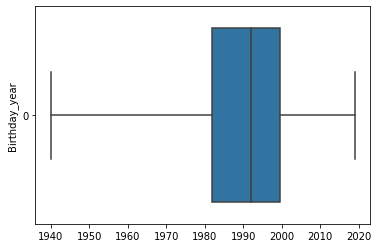

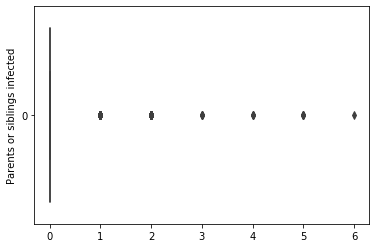

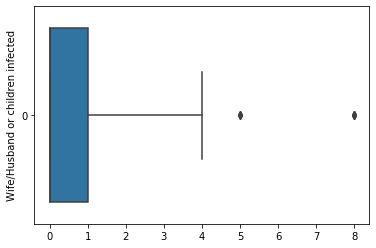

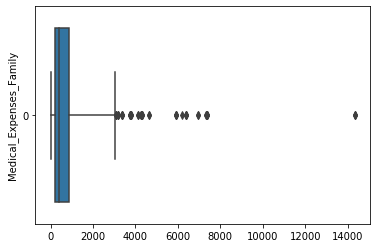

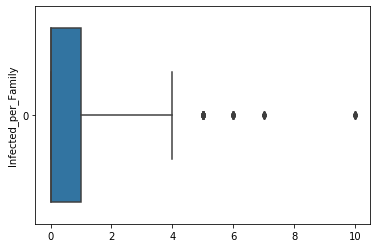

In [30]:
col = ['Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Medical_Expenses_Family','Infected_per_Family']

for c in col:
    sns.boxplot(data=data[c],orient='h',whis=3.5)
    plt.ylabel(c)
    plt.show()

In [31]:
def outliers(data, target, std=3, remove=False, pr=False):
    cols = []
    for col in ['Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Medical_Expenses_Family','Infected_per_Family']:
        if col in data.columns:
            cols.append(col)
    
    ind = []
    ind_to_remove = []
    
    if len(cols)>0:
        out = data[cols]
        out = pd.DataFrame(data=StandardScaler().fit_transform(out),index=out.index,columns=out.columns)

        for col in out.columns:
            ind_col = list(out[(out[col]<-std)|(out[col]>std)].index)
            ind += ind_col

        for i in ind:
            if i not in ind_to_remove:
                ind_to_remove.append(i)
            
    if pr == True:
        print(len(ind_to_remove))
    
    if remove == True:
        for i in ind_to_remove:
            data = data.drop(i,0)
            target = target.drop(i,0)
        
        return data, target

In [32]:
outliers(data, target, pr=True)

66


This is around 7% of the data, and so an acceptable number of outliers to remove.

These outliers can be ignored or removed.

### Oversampling

Since the target variable is unbalanced, a hypothesis is to balance the dataset through oversampling. Undersampling was not considered because there's not much data to begin with.

In [33]:
def oversample(data, target):
    X = pd.concat([data, target], axis=1)      

    false = X[X.Deceased==0]
    true = X[X.Deceased==1]    

    false_upsampled = resample(false,
                               replace=True, # sample with replacement
                               n_samples=len(medium), # match number in majority class
                               random_state=27) # reproducible results        

    upsampled = pd.concat([false_upsampled, true])

    data = upsampled.drop(['Deceased'],1)
    target = upsampled['Deceased']   

    return data, target

## Tuning Hyperparameters

In [38]:
def avg_score(model, method='knn', k=1, remove=False, std=3, oversampling=False, scaler=MinMaxScaler(), grid_search=False, parameters=None, features=False):
    # apply kfold
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    n_iter = []
    
    data__ = data.drop('Name',1)
    
    """cat_col = []
    num_col = []

    for col in data__.columns:
        if col in ['Severity','City','Marital_Status','Gender','Title','Is_young']:
            cat_col.append(col)
        elif col in ['Family_Case_ID','Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Medical_Expenses_Family','Infected_per_Family']:
            num_col.append(col)
    
    anova = pd.Series(data=0,index=num_col)
    chi = pd.Series(data=0,index=cat_col)"""
    
    for train_index, test_index in kf.split(data__,target):
        # get the indexes of the observations assigned for each partition
        X_train, X_test = data__.iloc[train_index], data__.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # deal with the null values
        X_train = null_values(X_train, method=method, k=k)
        X_test = null_values(X_test, method=method,k=k)
        
        # deal with outliers
        if remove == True:
            X_train, y_train = outliers(X_train, y_train, std=std, remove=remove)
        
        # oversample the minority class
        if oversampling == True:
            X_train, y_train = oversample(X_train, y_train)
            
        """if features == True:
            data_cat = X_train[cat_col]
            data_num = X_train[num_col]
            
            anova_ = pd.Series(data=f_classif(data_num,y_train)[0],index=data_num.columns)
            chi_ = pd.Series(data=chi2(data_cat,y_train)[0],index=data_cat.columns)
            
            anova += anova_
            chi += chi_"""
            
        # scale the data
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # start counting time
        begin = time.perf_counter()
        
        # find the best features
        if features == True:
            rfe = RFECV(estimator = model,n_jobs=-1,scoring='accuracy')
            X_train = rfe.fit_transform(X_train,y_train)
            X_test = rfe.transform(X_test)
        
        # find the best hyperparameters
        if grid_search == True:
            clf = RandomizedSearchCV(model,parameters,n_jobs=-1,scoring='accuracy',n_iter=10,random_state=0)
            clf.fit(X_train,y_train)
            model = clf.best_estimator_
            print(clf.best_params_)
            
        # fit the model to the data
        model.fit(X_train, y_train)
        
        # finish counting time
        end = time.perf_counter()
        
        # predictions
        Y_pred = model.predict(X_train)
        y_pred = model.predict(X_test)
        
        # check the mean f1-score for the train
        value_train = model.score(X_train,y_train)
        
        # check the mean f1-score for the test
        value_test = model.score(X_test,y_test)
        
        # print a classification report and confusion matrix
        print(classification_report(y_true=y_test,y_pred=y_pred))
        print(confusion_matrix(y_true=y_test,y_pred=y_pred))
        
        # append the scores, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    """if features == True:
        anova = anova.sort_values(ascending=False)
        chi = chi.sort_values(ascending=False)
        
        print(anova)
        print(chi)"""
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test)

In [39]:
def show_results(df, models, method = 'knn', k = 1, remove = False, std = 3, oversampling = False, scaler = MinMaxScaler(), parameters = None,features=False):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for model in models:
        parameter_space = None
        if parameters != None:
            parameter_space = parameters[models.index(model)]
            
        if parameter_space == None:
            grid_search = False
        else:
            grid_search = True
                
        print('----------------------------------')
        # obtain the results provided by avg_score
        time, avg_train, avg_test = avg_score(model, method = method, k = k, remove = remove, std = std, oversampling = oversampling, grid_search = grid_search, scaler = scaler, parameters = parameter_space, features = features)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test
        count+=1

    return df

In [40]:
model = GaussianNB()

In [41]:
df = pd.DataFrame(columns=['Time','Train','Test'])
show_results(df,[model])

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.77      0.74        69
           1       0.85      0.81      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
weighted avg       0.80      0.79      0.80       180

[[53 16]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.75      0.70        69
           1       0.83      0.76      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [27 84]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        69
           1       0.85      0.79      0.82       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.78       180
w

IndexError: single positional indexer is out-of-bounds

## Tests

### Data Cleaning and Scaling

Given that there are so many alternatives on how to clean and scale the data, they're going to be tested against each other.

In [42]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model])

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.77      0.74        69
           1       0.85      0.81      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
weighted avg       0.80      0.79      0.80       180

[[53 16]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.75      0.70        69
           1       0.83      0.76      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [27 84]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        69
           1       0.85      0.79      0.82       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.78       180
w

,Time,Train,Test
model,0.002+/-0.0,0.774+/-0.01,0.776+/-0.02


In [43]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.77      0.74        69
           1       0.85      0.81      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
weighted avg       0.80      0.79      0.80       180

[[53 16]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.75      0.70        69
           1       0.83      0.76      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [27 84]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        69
           1       0.85      0.79      0.82       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.78       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.01,0.776+/-0.02


In [44]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.77      0.74        69
           1       0.85      0.81      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
weighted avg       0.80      0.79      0.80       180

[[53 16]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.75      0.70        69
           1       0.83      0.76      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [27 84]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        69
           1       0.85      0.79      0.82       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.78       180
w

,Time,Train,Test
model,0.002+/-0.0,0.774+/-0.01,0.776+/-0.02


In [45]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.77      0.74        69
           1       0.85      0.81      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
weighted avg       0.80      0.79      0.80       180

[[53 16]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.75      0.70        69
           1       0.83      0.76      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [27 84]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        69
           1       0.85      0.79      0.82       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.78       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.01,0.776+/-0.02


In [46]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True)

----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.71      0.67        69
           1       0.81      0.75      0.78       111

    accuracy                           0.73       180
   macro avg       0.72      0.73      0.72       180
weighted avg       0.74      0.73      0.74       180

[[49 20]
 [28 83]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
w

,Time,Train,Test
model,0.001+/-0.0,0.773+/-0.01,0.746+/-0.03


In [47]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.71      0.67        69
           1       0.81      0.75      0.78       111

    accuracy                           0.73       180
   macro avg       0.72      0.73      0.72       180
weighted avg       0.74      0.73      0.74       180

[[49 20]
 [28 83]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
w

,Time,Train,Test
model,0.001+/-0.0,0.773+/-0.01,0.746+/-0.03


In [48]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.71      0.67        69
           1       0.81      0.75      0.78       111

    accuracy                           0.73       180
   macro avg       0.72      0.73      0.72       180
weighted avg       0.74      0.73      0.74       180

[[49 20]
 [28 83]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
w

,Time,Train,Test
model,0.002+/-0.0,0.773+/-0.01,0.746+/-0.03


In [49]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.71      0.67        69
           1       0.81      0.75      0.78       111

    accuracy                           0.73       180
   macro avg       0.72      0.73      0.72       180
weighted avg       0.74      0.73      0.74       180

[[49 20]
 [28 83]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
w

,Time,Train,Test
model,0.001+/-0.0,0.773+/-0.01,0.746+/-0.03


In [50]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,std=4)

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [20 91]]
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        69
           1       0.80      0.71      0.75       111

    accuracy                           0.71       180
   macro avg       0.70      0.71      0.70       180
weighted avg       0.72      0.71      0.71       180

[[49 20]
 [32 79]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.73        69
           1       0.86      0.77      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.778+/-0.0,0.761+/-0.03


In [51]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,std=4,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [20 91]]
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        69
           1       0.80      0.71      0.75       111

    accuracy                           0.71       180
   macro avg       0.70      0.71      0.70       180
weighted avg       0.72      0.71      0.71       180

[[49 20]
 [32 79]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.73        69
           1       0.86      0.77      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.778+/-0.0,0.761+/-0.03


In [52]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,std=4,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [20 91]]
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        69
           1       0.80      0.71      0.75       111

    accuracy                           0.71       180
   macro avg       0.70      0.71      0.70       180
weighted avg       0.72      0.71      0.71       180

[[49 20]
 [32 79]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.73        69
           1       0.86      0.77      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
w

,Time,Train,Test
model,0.002+/-0.0,0.778+/-0.0,0.761+/-0.03


In [53]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,std=4,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [20 91]]
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        69
           1       0.80      0.71      0.75       111

    accuracy                           0.71       180
   macro avg       0.70      0.71      0.70       180
weighted avg       0.72      0.71      0.71       180

[[49 20]
 [32 79]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.73        69
           1       0.86      0.77      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.778+/-0.0,0.761+/-0.03


In [54]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2)

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.75      0.70        69
           1       0.83      0.76      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [27 84]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.776+/-0.01,0.776+/-0.02


In [55]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.75      0.70        69
           1       0.83      0.76      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [27 84]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.776+/-0.01,0.776+/-0.02


In [56]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.75      0.70        69
           1       0.83      0.76      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [27 84]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.776+/-0.01,0.776+/-0.02


In [57]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.75      0.70        69
           1       0.83      0.76      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [27 84]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.776+/-0.01,0.776+/-0.02


In [58]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True)

----------------------------------
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        69
           1       0.82      0.77      0.79       111

    accuracy                           0.75       180
   macro avg       0.74      0.75      0.74       180
weighted avg       0.76      0.75      0.75       180

[[50 19]
 [26 85]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
w

,Time,Train,Test
model,0.001+/-0.0,0.776+/-0.01,0.747+/-0.03


In [59]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        69
           1       0.82      0.77      0.79       111

    accuracy                           0.75       180
   macro avg       0.74      0.75      0.74       180
weighted avg       0.76      0.75      0.75       180

[[50 19]
 [26 85]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
w

,Time,Train,Test
model,0.001+/-0.0,0.776+/-0.01,0.747+/-0.03


In [60]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        69
           1       0.82      0.77      0.79       111

    accuracy                           0.75       180
   macro avg       0.74      0.75      0.74       180
weighted avg       0.76      0.75      0.75       180

[[50 19]
 [26 85]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
w

,Time,Train,Test
model,0.001+/-0.0,0.776+/-0.01,0.747+/-0.03


In [61]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        69
           1       0.82      0.77      0.79       111

    accuracy                           0.75       180
   macro avg       0.74      0.75      0.74       180
weighted avg       0.76      0.75      0.75       180

[[50 19]
 [26 85]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
w

,Time,Train,Test
model,0.002+/-0.0,0.776+/-0.01,0.747+/-0.03


In [62]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4)

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.74      0.68        69
           1       0.82      0.72      0.77       111

    accuracy                           0.73       180
   macro avg       0.72      0.73      0.72       180
weighted avg       0.74      0.73      0.73       180

[[51 18]
 [31 80]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        69
           1       0.86      0.76      0.80       111

    accuracy                           0.77       180
   macro avg       0.76      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.78+/-0.01,0.763+/-0.02


In [63]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.74      0.68        69
           1       0.82      0.72      0.77       111

    accuracy                           0.73       180
   macro avg       0.72      0.73      0.72       180
weighted avg       0.74      0.73      0.73       180

[[51 18]
 [31 80]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        69
           1       0.86      0.76      0.80       111

    accuracy                           0.77       180
   macro avg       0.76      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.78+/-0.01,0.763+/-0.02


In [64]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.74      0.68        69
           1       0.82      0.72      0.77       111

    accuracy                           0.73       180
   macro avg       0.72      0.73      0.72       180
weighted avg       0.74      0.73      0.73       180

[[51 18]
 [31 80]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        69
           1       0.86      0.76      0.80       111

    accuracy                           0.77       180
   macro avg       0.76      0.78      0.77       180
w

,Time,Train,Test
model,0.002+/-0.0,0.78+/-0.01,0.763+/-0.02


In [65]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.74      0.68        69
           1       0.82      0.72      0.77       111

    accuracy                           0.73       180
   macro avg       0.72      0.73      0.72       180
weighted avg       0.74      0.73      0.73       180

[[51 18]
 [31 80]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        69
           1       0.86      0.76      0.80       111

    accuracy                           0.77       180
   macro avg       0.76      0.78      0.77       180
w

,Time,Train,Test
model,0.002+/-0.0,0.78+/-0.01,0.763+/-0.02


In [66]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3)

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.74      0.70        69
           1       0.83      0.77      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[51 18]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.775+/-0.01,0.776+/-0.02


In [67]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.74      0.70        69
           1       0.83      0.77      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[51 18]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.775+/-0.01,0.776+/-0.02


In [68]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.74      0.70        69
           1       0.83      0.77      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[51 18]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.775+/-0.01,0.776+/-0.02


In [69]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.74      0.70        69
           1       0.83      0.77      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[51 18]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.002+/-0.0,0.775+/-0.01,0.776+/-0.02


In [70]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True)

----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.72      0.68        69
           1       0.81      0.75      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.74       180

[[50 19]
 [28 83]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
w

,Time,Train,Test
model,0.001+/-0.0,0.776+/-0.01,0.742+/-0.03


In [71]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.72      0.68        69
           1       0.81      0.75      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.74       180

[[50 19]
 [28 83]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
w

,Time,Train,Test
model,0.002+/-0.0,0.776+/-0.01,0.742+/-0.03


In [72]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.72      0.68        69
           1       0.81      0.75      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.74       180

[[50 19]
 [28 83]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
w

,Time,Train,Test
model,0.001+/-0.0,0.776+/-0.01,0.742+/-0.03


In [73]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.72      0.68        69
           1       0.81      0.75      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.74       180

[[50 19]
 [28 83]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
w

,Time,Train,Test
model,0.002+/-0.0,0.776+/-0.01,0.742+/-0.03


In [74]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4)

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[50 19]
 [31 80]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        69
           1       0.86      0.76      0.80       111

    accuracy                           0.77       180
   macro avg       0.76      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.779+/-0.0,0.761+/-0.02


In [75]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[50 19]
 [31 80]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        69
           1       0.86      0.76      0.80       111

    accuracy                           0.77       180
   macro avg       0.76      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.779+/-0.0,0.761+/-0.02


In [76]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[50 19]
 [31 80]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        69
           1       0.86      0.76      0.80       111

    accuracy                           0.77       180
   macro avg       0.76      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.779+/-0.0,0.761+/-0.02


In [77]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[50 19]
 [31 80]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        69
           1       0.86      0.76      0.80       111

    accuracy                           0.77       180
   macro avg       0.76      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.779+/-0.0,0.761+/-0.02


In [78]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4)

----------------------------------
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.74      0.70        69
           1       0.83      0.77      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[51 18]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.002+/-0.0,0.776+/-0.01,0.773+/-0.02


In [79]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.74      0.70        69
           1       0.83      0.77      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[51 18]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.002+/-0.0,0.776+/-0.01,0.773+/-0.02


In [80]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.74      0.70        69
           1       0.83      0.77      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[51 18]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.776+/-0.01,0.773+/-0.02


In [81]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [21 90]]
              precision    recall  f1-score   support

           0       0.66      0.74      0.70        69
           1       0.83      0.77      0.79       111

    accuracy                           0.76       180
   macro avg       0.74      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[51 18]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.776+/-0.01,0.773+/-0.02


In [82]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True)

----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.71      0.68        69
           1       0.81      0.76      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.73      0.73       180
weighted avg       0.75      0.74      0.74       180

[[49 20]
 [27 84]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83      0.66      0.73       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.01,0.743+/-0.03


In [83]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.71      0.68        69
           1       0.81      0.76      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.73      0.73       180
weighted avg       0.75      0.74      0.74       180

[[49 20]
 [27 84]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83      0.66      0.73       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
w

,Time,Train,Test
model,0.002+/-0.0,0.774+/-0.01,0.743+/-0.03


In [84]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.71      0.68        69
           1       0.81      0.76      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.73      0.73       180
weighted avg       0.75      0.74      0.74       180

[[49 20]
 [27 84]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83      0.66      0.73       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.01,0.743+/-0.03


In [85]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.71      0.68        69
           1       0.81      0.76      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.73      0.73       180
weighted avg       0.75      0.74      0.74       180

[[49 20]
 [27 84]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83      0.66      0.73       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.01,0.743+/-0.03


In [86]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4)

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[50 19]
 [31 80]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.73        69
           1       0.86      0.77      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.778+/-0.01,0.76+/-0.02


In [87]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[50 19]
 [31 80]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.73        69
           1       0.86      0.77      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
w

,Time,Train,Test
model,0.002+/-0.0,0.778+/-0.01,0.76+/-0.02


In [88]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[50 19]
 [31 80]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.73        69
           1       0.86      0.77      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.778+/-0.01,0.76+/-0.02


In [89]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[50 19]
 [31 80]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.73        69
           1       0.86      0.77      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.778+/-0.01,0.76+/-0.02


In [90]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5)

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        69
           1       0.83      0.77      0.80       111

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.002+/-0.0,0.774+/-0.01,0.776+/-0.01


In [91]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        69
           1       0.83      0.77      0.80       111

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.01,0.776+/-0.01


In [92]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        69
           1       0.83      0.77      0.80       111

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.01,0.776+/-0.01


In [93]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        69
           1       0.83      0.77      0.80       111

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.80      0.83       111

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
w

,Time,Train,Test
model,0.002+/-0.0,0.774+/-0.01,0.776+/-0.01


In [94]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True)

----------------------------------
              precision    recall  f1-score   support

           0       0.65      0.72      0.68        69
           1       0.82      0.76      0.79       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.75       180

[[50 19]
 [27 84]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83      0.66      0.73       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.01,0.744+/-0.03


In [95]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.65      0.72      0.68        69
           1       0.82      0.76      0.79       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.75       180

[[50 19]
 [27 84]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83      0.66      0.73       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.01,0.744+/-0.03


In [96]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.65      0.72      0.68        69
           1       0.82      0.76      0.79       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.75       180

[[50 19]
 [27 84]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83      0.66      0.73       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
w

,Time,Train,Test
model,0.002+/-0.0,0.774+/-0.01,0.744+/-0.03


In [97]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.65      0.72      0.68        69
           1       0.82      0.76      0.79       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.75       180

[[50 19]
 [27 84]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.68        69
           1       0.83      0.67      0.74       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.71      0.72       180

[[54 15]
 [37 74]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83      0.66      0.73       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.01,0.744+/-0.03


In [98]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4)

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[50 19]
 [31 80]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.73        69
           1       0.86      0.77      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
w

,Time,Train,Test
model,0.002+/-0.0,0.778+/-0.01,0.763+/-0.02


In [99]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[50 19]
 [31 80]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.73        69
           1       0.86      0.77      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.778+/-0.01,0.763+/-0.02


In [100]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[50 19]
 [31 80]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.73        69
           1       0.86      0.77      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
w

,Time,Train,Test
model,0.002+/-0.0,0.778+/-0.01,0.763+/-0.02


In [101]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[50 19]
 [31 80]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.73        69
           1       0.86      0.77      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
w

,Time,Train,Test
model,0.001+/-0.0,0.778+/-0.01,0.763+/-0.02


In [102]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat')

----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.75      0.72        69
           1       0.84      0.78      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.77      0.76       180
weighted avg       0.78      0.77      0.77       180

[[52 17]
 [24 87]]
              precision    recall  f1-score   support

           0       0.65      0.74      0.69        69
           1       0.82      0.75      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.74       180
weighted avg       0.75      0.74      0.75       180

[[51 18]
 [28 83]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.79      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.772+/-0.01,0.768+/-0.02


In [103]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.75      0.72        69
           1       0.84      0.78      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.77      0.76       180
weighted avg       0.78      0.77      0.77       180

[[52 17]
 [24 87]]
              precision    recall  f1-score   support

           0       0.65      0.74      0.69        69
           1       0.82      0.75      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.74       180
weighted avg       0.75      0.74      0.75       180

[[51 18]
 [28 83]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.79      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.772+/-0.01,0.768+/-0.02


In [104]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.75      0.72        69
           1       0.84      0.78      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.77      0.76       180
weighted avg       0.78      0.77      0.77       180

[[52 17]
 [24 87]]
              precision    recall  f1-score   support

           0       0.65      0.74      0.69        69
           1       0.82      0.75      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.74       180
weighted avg       0.75      0.74      0.75       180

[[51 18]
 [28 83]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.79      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.772+/-0.01,0.768+/-0.02


In [105]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.75      0.72        69
           1       0.84      0.78      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.77      0.76       180
weighted avg       0.78      0.77      0.77       180

[[52 17]
 [24 87]]
              precision    recall  f1-score   support

           0       0.65      0.74      0.69        69
           1       0.82      0.75      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.74       180
weighted avg       0.75      0.74      0.75       180

[[51 18]
 [28 83]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.79      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
w

,Time,Train,Test
model,0.001+/-0.0,0.772+/-0.01,0.768+/-0.02


In [106]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True)

----------------------------------
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        69
           1       0.83      0.77      0.80       111

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [26 85]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83      0.66      0.73       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
weighted avg       0.74      0.71      0.71       180

[[54 15]
 [38 73]]
              precision    recall  f1-score   support

           0       0.60      0.78      0.68        69
           1       0.83      0.68      0.75       111

    accuracy                           0.72       180
   macro avg       0.72      0.73      0.71       180
w

,Time,Train,Test
model,0.001+/-0.0,0.775+/-0.01,0.747+/-0.03


In [107]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        69
           1       0.83      0.77      0.80       111

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [26 85]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83      0.66      0.73       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
weighted avg       0.74      0.71      0.71       180

[[54 15]
 [38 73]]
              precision    recall  f1-score   support

           0       0.60      0.78      0.68        69
           1       0.83      0.68      0.75       111

    accuracy                           0.72       180
   macro avg       0.72      0.73      0.71       180
w

,Time,Train,Test
model,0.001+/-0.0,0.775+/-0.01,0.747+/-0.03


In [108]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        69
           1       0.83      0.77      0.80       111

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [26 85]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83      0.66      0.73       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
weighted avg       0.74      0.71      0.71       180

[[54 15]
 [38 73]]
              precision    recall  f1-score   support

           0       0.60      0.78      0.68        69
           1       0.83      0.68      0.75       111

    accuracy                           0.72       180
   macro avg       0.72      0.73      0.71       180
w

,Time,Train,Test
model,0.001+/-0.0,0.775+/-0.01,0.747+/-0.03


In [109]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        69
           1       0.83      0.77      0.80       111

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[52 17]
 [26 85]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83      0.66      0.73       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
weighted avg       0.74      0.71      0.71       180

[[54 15]
 [38 73]]
              precision    recall  f1-score   support

           0       0.60      0.78      0.68        69
           1       0.83      0.68      0.75       111

    accuracy                           0.72       180
   macro avg       0.72      0.73      0.71       180
w

,Time,Train,Test
model,0.001+/-0.0,0.775+/-0.01,0.747+/-0.03


In [110]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4)

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        69
           1       0.80      0.70      0.75       111

    accuracy                           0.71       180
   macro avg       0.70      0.71      0.70       180
weighted avg       0.72      0.71      0.71       180

[[49 20]
 [33 78]]
              precision    recall  f1-score   support

           0       0.69      0.83      0.75        69
           1       0.88      0.77      0.82       111

    accuracy                           0.79       180
   macro avg       0.78      0.80      0.78       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.0,0.763+/-0.03


In [111]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,scaler=StandardScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        69
           1       0.80      0.70      0.75       111

    accuracy                           0.71       180
   macro avg       0.70      0.71      0.70       180
weighted avg       0.72      0.71      0.71       180

[[49 20]
 [33 78]]
              precision    recall  f1-score   support

           0       0.69      0.83      0.75        69
           1       0.88      0.77      0.82       111

    accuracy                           0.79       180
   macro avg       0.78      0.80      0.78       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.0,0.763+/-0.03


In [112]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        69
           1       0.80      0.70      0.75       111

    accuracy                           0.71       180
   macro avg       0.70      0.71      0.70       180
weighted avg       0.72      0.71      0.71       180

[[49 20]
 [33 78]]
              precision    recall  f1-score   support

           0       0.69      0.83      0.75        69
           1       0.88      0.77      0.82       111

    accuracy                           0.79       180
   macro avg       0.78      0.80      0.78       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.0,0.763+/-0.03


In [113]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        69
           1       0.80      0.70      0.75       111

    accuracy                           0.71       180
   macro avg       0.70      0.71      0.70       180
weighted avg       0.72      0.71      0.71       180

[[49 20]
 [33 78]]
              precision    recall  f1-score   support

           0       0.69      0.83      0.75        69
           1       0.88      0.77      0.82       111

    accuracy                           0.79       180
   macro avg       0.78      0.80      0.78       180
w

,Time,Train,Test
model,0.001+/-0.0,0.774+/-0.0,0.763+/-0.03


In [114]:
data.head()

,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Infected_per_Family,Marital_Status,Gender,Title,Is_young
0,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,1.0,0,0.0,1,1,NaN
1,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,0.0,1,NaN,1,3,1.0
2,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,1.0,0,1.0,0,2,1.0
3,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,1.0,0,1.0,0,2,1.0
4,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,1.0,0,NaN,1,3,1.0


In [115]:
data_ = data

In [116]:
data_.head()

,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Infected_per_Family,Marital_Status,Gender,Title,Is_young
0,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,1.0,0,0.0,1,1,NaN
1,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,0.0,1,NaN,1,3,1.0
2,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,1.0,0,1.0,0,2,1.0
3,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,1.0,0,1.0,0,2,1.0
4,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,1.0,0,NaN,1,3,1.0


In [117]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=2))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        69
           1       0.84      0.81      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[52 17]
 [21 90]]
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        69
           1       0.81      0.79      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [23 88]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0


[[52 18]
 [25 85]]
              precision    recall  f1-score   support

           0       0.70      0.79      0.74        70
           1       0.85      0.78      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.78       180
weighted avg       0.79      0.78      0.79       180

[[55 15]
 [24 86]]
              Time         Train          Test
model  0.002+/-0.0  0.782+/-0.01  0.767+/-0.02
Medical_Expenses_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.78      0.71        69
           1       0.84      0.73      0.78       111

    accuracy                           0.75       180
   macro avg       0.74      0.76      0.74       180
weighted avg       0.77      0.75      0.75       180

[[54 15]
 [30 81]]
              precision    recall  f1-score   support

           0       0.65      0.81      0.72        69
           1       0.86   

              precision    recall  f1-score   support

           0       0.56      0.72      0.63        69
           1       0.79      0.64      0.71       111

    accuracy                           0.67       180
   macro avg       0.67      0.68      0.67       180
weighted avg       0.70      0.67      0.68       180

[[50 19]
 [40 71]]
              precision    recall  f1-score   support

           0       0.57      0.84      0.68        69
           1       0.86      0.61      0.72       111

    accuracy                           0.70       180
   macro avg       0.72      0.73      0.70       180
weighted avg       0.75      0.70      0.70       180

[[58 11]
 [43 68]]
              precision    recall  f1-score   support

           0       0.51      0.80      0.63        70
           1       0.80      0.52      0.63       110

    accuracy                           0.63       180
   macro avg       0.66      0.66      0.63       180
weighted avg       0.69      0.63   

In [118]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],method='stat',scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.69      0.77      0.73        69
           1       0.84      0.78      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.78      0.78      0.78       180

[[53 16]
 [24 87]]
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        69
           1       0.81      0.78      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.75      0.74       180
weighted avg       0.76      0.76      0.76       180

[[49 20]
 [24 87]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0


[[51 18]
 [29 82]]
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        69
           1       0.85      0.79      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78      0.79       180

[[53 16]
 [23 88]]
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        70
           1       0.83      0.78      0.80       110

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[52 18]
 [24 86]]
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        70
           1       0.84      0.79      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.78       180
weighted avg    


[[53 17]
 [25 85]]
              Time         Train          Test
model  0.001+/-0.0  0.772+/-0.01  0.769+/-0.02
Gender
----------------------------------
              precision    recall  f1-score   support

           0       0.65      0.61      0.63        69
           1       0.77      0.79      0.78       111

    accuracy                           0.72       180
   macro avg       0.71      0.70      0.70       180
weighted avg       0.72      0.72      0.72       180

[[42 27]
 [23 88]]
              precision    recall  f1-score   support

           0       0.58      0.78      0.67        69
           1       0.83      0.65      0.73       111

    accuracy                           0.70       180
   macro avg       0.70      0.72      0.70       180
weighted avg       0.73      0.70      0.70       180

[[54 15]
 [39 72]]
              precision    recall  f1-score   support

           0       0.56      0.80      0.66        69
           1       0.83      0.61      0.70

In [119]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],method='stat',scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.69      0.77      0.73        69
           1       0.84      0.78      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.78      0.78      0.78       180

[[53 16]
 [24 87]]
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        69
           1       0.81      0.78      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.75      0.74       180
weighted avg       0.76      0.76      0.76       180

[[49 20]
 [24 87]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0


[[52 18]
 [24 86]]
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        70
           1       0.84      0.79      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.78       180
weighted avg       0.79      0.78      0.78       180

[[54 16]
 [23 87]]
              Time         Train          Test
model  0.001+/-0.0  0.778+/-0.01  0.772+/-0.02
Medical_Expenses_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.66      0.77      0.71        69
           1       0.84      0.76      0.80       111

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[53 16]
 [27 84]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83   

[[52 18]
 [58 52]]
              precision    recall  f1-score   support

           0       0.43      0.81      0.56        70
           1       0.73      0.32      0.44       110

    accuracy                           0.51       180
   macro avg       0.58      0.57      0.50       180
weighted avg       0.61      0.51      0.49       180

[[57 13]
 [75 35]]
              Time         Train          Test
model  0.001+/-0.0  0.641+/-0.05  0.639+/-0.08
Title
----------------------------------
              precision    recall  f1-score   support

           0       0.67      0.77      0.72        69
           1       0.84      0.77      0.80       111

    accuracy                           0.77       180
   macro avg       0.76      0.77      0.76       180
weighted avg       0.78      0.77      0.77       180

[[53 16]
 [26 85]]
              precision    recall  f1-score   support

           0       0.65      0.78      0.71        69
           1       0.85      0.74      0.79  

In [120]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=5,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.79      0.78      0.78       180

[[51 18]
 [21 90]]
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        69
           1       0.81      0.80      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [22 89]]
              precision    recall  f1-score   support

           0       0.73      0.70      0.71        69
           1       0.82      0.84      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0

              precision    recall  f1-score   support

           0       0.68      0.72      0.70        69
           1       0.82      0.79      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[50 19]
 [23 88]]
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        70
           1       0.83      0.78      0.80       110

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[52 18]
 [24 86]]
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        70
           1       0.85      0.80      0.83       110

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
weighted avg       0.80      0.79   


[[53 17]
 [25 85]]
              Time         Train          Test
model  0.002+/-0.0  0.772+/-0.01  0.768+/-0.02
Gender
----------------------------------
              precision    recall  f1-score   support

           0       0.63      0.58      0.61        69
           1       0.75      0.79      0.77       111

    accuracy                           0.71       180
   macro avg       0.69      0.69      0.69       180
weighted avg       0.71      0.71      0.71       180

[[40 29]
 [23 88]]
              precision    recall  f1-score   support

           0       0.58      0.77      0.66        69
           1       0.82      0.65      0.72       111

    accuracy                           0.69       180
   macro avg       0.70      0.71      0.69       180
weighted avg       0.73      0.69      0.70       180

[[53 16]
 [39 72]]
              precision    recall  f1-score   support

           0       0.60      0.86      0.71        69
           1       0.88      0.65      0.75

In [121]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.67      0.77      0.72        69
           1       0.84      0.77      0.80       111

    accuracy                           0.77       180
   macro avg       0.76      0.77      0.76       180
weighted avg       0.78      0.77      0.77       180

[[53 16]
 [26 85]]
              precision    recall  f1-score   support

           0       0.61      0.72      0.66        69
           1       0.81      0.71      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.72       180

[[50 19]
 [32 79]]
              precision    recall  f1-score   support

           0       0.64      0.75      0.69        69
           1       0.83      0.74      0.78       111

    accuracy                           0.74       180
   macro avg       0.74      0.75      0

              precision    recall  f1-score   support

           0       0.63      0.81      0.71        69
           1       0.86      0.70      0.77       111

    accuracy                           0.74       180
   macro avg       0.74      0.76      0.74       180
weighted avg       0.77      0.74      0.75       180

[[56 13]
 [33 78]]
              precision    recall  f1-score   support

           0       0.67      0.77      0.72        70
           1       0.84      0.75      0.79       110

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[54 16]
 [27 83]]
              precision    recall  f1-score   support

           0       0.70      0.79      0.74        70
           1       0.85      0.78      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.78       180
weighted avg       0.79      0.78   

              precision    recall  f1-score   support

           0       0.55      0.61      0.58        69
           1       0.74      0.69      0.72       111

    accuracy                           0.66       180
   macro avg       0.65      0.65      0.65       180
weighted avg       0.67      0.66      0.66       180

[[42 27]
 [34 77]]
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        69
           1       0.76      0.70      0.73       111

    accuracy                           0.68       180
   macro avg       0.67      0.68      0.67       180
weighted avg       0.69      0.68      0.69       180

[[45 24]
 [33 78]]
              precision    recall  f1-score   support

           0       0.61      0.67      0.64        70
           1       0.78      0.73      0.75       110

    accuracy                           0.71       180
   macro avg       0.69      0.70      0.70       180
weighted avg       0.71      0.71   

In [122]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        69
           1       0.81      0.77      0.79       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.75       180

[[49 20]
 [26 85]]
              precision    recall  f1-score   support

           0       0.61      0.75      0.68        69
           1       0.82      0.70      0.76       111

    accuracy                           0.72       180
   macro avg       0.72      0.73      0.72       180
weighted avg       0.74      0.72      0.73       180

[[52 17]
 [33 78]]
              precision    recall  f1-score   support

           0       0.64      0.74      0.68        69
           1       0.82      0.74      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0

              precision    recall  f1-score   support

           0       0.68      0.79      0.73        70
           1       0.85      0.76      0.80       110

    accuracy                           0.77       180
   macro avg       0.76      0.77      0.77       180
weighted avg       0.78      0.77      0.77       180

[[55 15]
 [26 84]]
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        70
           1       0.84      0.79      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.78       180
weighted avg       0.79      0.78      0.78       180

[[54 16]
 [23 87]]
              Time         Train          Test
model  0.002+/-0.0  0.773+/-0.01  0.754+/-0.03
Medical_Expenses_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.63      0.70      0.66        69
           1       0.80      0.75      0.77   

              precision    recall  f1-score   support

           0       0.57      0.51      0.54        69
           1       0.71      0.77      0.74       111

    accuracy                           0.67       180
   macro avg       0.64      0.64      0.64       180
weighted avg       0.66      0.67      0.66       180

[[35 34]
 [26 85]]
              precision    recall  f1-score   support

           0       0.55      0.64      0.59        69
           1       0.75      0.68      0.71       111

    accuracy                           0.66       180
   macro avg       0.65      0.66      0.65       180
weighted avg       0.67      0.66      0.66       180

[[44 25]
 [36 75]]
              precision    recall  f1-score   support

           0       0.58      0.67      0.62        69
           1       0.77      0.70      0.74       111

    accuracy                           0.69       180
   macro avg       0.68      0.68      0.68       180
weighted avg       0.70      0.69   

In [123]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        69
           1       0.81      0.77      0.79       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.75       180

[[49 20]
 [26 85]]
              precision    recall  f1-score   support

           0       0.61      0.75      0.68        69
           1       0.82      0.70      0.76       111

    accuracy                           0.72       180
   macro avg       0.72      0.73      0.72       180
weighted avg       0.74      0.72      0.73       180

[[52 17]
 [33 78]]
              precision    recall  f1-score   support

           0       0.64      0.74      0.68        69
           1       0.82      0.74      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0


[[53 16]
 [34 77]]
              precision    recall  f1-score   support

           0       0.68      0.79      0.73        70
           1       0.85      0.76      0.80       110

    accuracy                           0.77       180
   macro avg       0.76      0.77      0.77       180
weighted avg       0.78      0.77      0.77       180

[[55 15]
 [26 84]]
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        70
           1       0.84      0.79      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.78       180
weighted avg       0.79      0.78      0.78       180

[[54 16]
 [23 87]]
              Time         Train          Test
model  0.001+/-0.0  0.773+/-0.01  0.754+/-0.03
Medical_Expenses_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.63      0.70      0.66        69
           1       0.80   

              precision    recall  f1-score   support

           0       0.57      0.51      0.54        69
           1       0.71      0.77      0.74       111

    accuracy                           0.67       180
   macro avg       0.64      0.64      0.64       180
weighted avg       0.66      0.67      0.66       180

[[35 34]
 [26 85]]
              precision    recall  f1-score   support

           0       0.55      0.64      0.59        69
           1       0.75      0.68      0.71       111

    accuracy                           0.66       180
   macro avg       0.65      0.66      0.65       180
weighted avg       0.67      0.66      0.66       180

[[44 25]
 [36 75]]
              precision    recall  f1-score   support

           0       0.58      0.67      0.62        69
           1       0.77      0.70      0.74       111

    accuracy                           0.69       180
   macro avg       0.68      0.68      0.68       180
weighted avg       0.70      0.69   

In [124]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=1,remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.71      0.68        69
           1       0.81      0.76      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.73      0.73       180
weighted avg       0.75      0.74      0.74       180

[[49 20]
 [27 84]]
              precision    recall  f1-score   support

           0       0.60      0.74      0.66        69
           1       0.81      0.69      0.75       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
weighted avg       0.73      0.71      0.71       180

[[51 18]
 [34 77]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.73      0.77       111

    accuracy                           0.73       180
   macro avg       0.72      0.73      0

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        70
           1       0.86      0.75      0.80       110

    accuracy                           0.77       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.77      0.77       180

[[56 14]
 [27 83]]
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        70
           1       0.84      0.79      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.78       180
weighted avg       0.79      0.78      0.78       180

[[54 16]
 [23 87]]
              Time        Train         Test
model  0.001+/-0.0  0.773+/-0.0  0.75+/-0.03
Medical_Expenses_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        69
           1       0.80      0.76      0.78       

              precision    recall  f1-score   support

           0       0.60      0.52      0.56        69
           1       0.72      0.78      0.75       111

    accuracy                           0.68       180
   macro avg       0.66      0.65      0.66       180
weighted avg       0.68      0.68      0.68       180

[[36 33]
 [24 87]]
              precision    recall  f1-score   support

           0       0.55      0.64      0.59        69
           1       0.75      0.68      0.71       111

    accuracy                           0.66       180
   macro avg       0.65      0.66      0.65       180
weighted avg       0.67      0.66      0.66       180

[[44 25]
 [36 75]]
              precision    recall  f1-score   support

           0       0.58      0.68      0.63        69
           1       0.78      0.69      0.73       111

    accuracy                           0.69       180
   macro avg       0.68      0.69      0.68       180
weighted avg       0.70      0.69   

In [125]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],remove=True,std=4))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.66      0.71      0.69        69
           1       0.81      0.77      0.79       111

    accuracy                           0.75       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.75      0.75      0.75       180

[[49 20]
 [25 86]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        69
           1       0.82      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.76      0

              precision    recall  f1-score   support

           0       0.67      0.76      0.71        70
           1       0.83      0.76      0.80       110

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[53 17]
 [26 84]]
              precision    recall  f1-score   support

           0       0.71      0.79      0.74        70
           1       0.85      0.79      0.82       110

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.78       180
weighted avg       0.80      0.79      0.79       180

[[55 15]
 [23 87]]
              Time         Train          Test
model  0.002+/-0.0  0.771+/-0.01  0.759+/-0.03
Medical_Expenses_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        69
           1       0.82      0.78      0.80   

              precision    recall  f1-score   support

           0       0.60      0.48      0.53        69
           1       0.71      0.80      0.75       111

    accuracy                           0.68       180
   macro avg       0.66      0.64      0.64       180
weighted avg       0.67      0.68      0.67       180

[[33 36]
 [22 89]]
              precision    recall  f1-score   support

           0       0.59      0.68      0.64        69
           1       0.78      0.71      0.75       111

    accuracy                           0.70       180
   macro avg       0.69      0.70      0.69       180
weighted avg       0.71      0.70      0.70       180

[[47 22]
 [32 79]]
              precision    recall  f1-score   support

           0       0.64      0.77      0.70        69
           1       0.84      0.73      0.78       111

    accuracy                           0.74       180
   macro avg       0.74      0.75      0.74       180
weighted avg       0.76      0.74   

In [126]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.66      0.71      0.69        69
           1       0.81      0.77      0.79       111

    accuracy                           0.75       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.75      0.75      0.75       180

[[49 20]
 [25 86]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0

              precision    recall  f1-score   support

           0       0.71      0.76      0.73        70
           1       0.84      0.80      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78      0.78       180

[[53 17]
 [22 88]]
              precision    recall  f1-score   support

           0       0.70      0.79      0.74        70
           1       0.85      0.78      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.78       180
weighted avg       0.79      0.78      0.79       180

[[55 15]
 [24 86]]
              Time         Train          Test
model  0.001+/-0.0  0.772+/-0.01  0.764+/-0.03
Medical_Expenses_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        69
           1       0.82      0.79      0.81   

              precision    recall  f1-score   support

           0       0.60      0.45      0.51        69
           1       0.70      0.81      0.75       111

    accuracy                           0.67       180
   macro avg       0.65      0.63      0.63       180
weighted avg       0.66      0.67      0.66       180

[[31 38]
 [21 90]]
              precision    recall  f1-score   support

           0       0.60      0.70      0.64        69
           1       0.79      0.71      0.75       111

    accuracy                           0.71       180
   macro avg       0.70      0.70      0.70       180
weighted avg       0.72      0.71      0.71       180

[[48 21]
 [32 79]]
              precision    recall  f1-score   support

           0       0.65      0.77      0.71        69
           1       0.84      0.75      0.79       111

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76   

In [127]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True,std=4,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        69
           1       0.84      0.81      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[52 17]
 [21 90]]
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        69
           1       0.81      0.77      0.79       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.75       180

[[49 20]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0

[[55 14]
 [29 82]]
              precision    recall  f1-score   support

           0       0.68      0.76      0.72        70
           1       0.83      0.77      0.80       110

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[53 17]
 [25 85]]
              precision    recall  f1-score   support

           0       0.69      0.79      0.73        70
           1       0.85      0.77      0.81       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78      0.78       180

[[55 15]
 [25 85]]
              Time        Train          Test
model  0.001+/-0.0  0.77+/-0.01  0.759+/-0.03
Medical_Expenses_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        69
           1       0.83      

              precision    recall  f1-score   support

           0       0.65      0.77      0.70        69
           1       0.84      0.74      0.78       111

    accuracy                           0.75       180
   macro avg       0.74      0.75      0.74       180
weighted avg       0.76      0.75      0.75       180

[[53 16]
 [29 82]]
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        70
           1       0.75      0.62      0.68       110

    accuracy                           0.64       180
   macro avg       0.64      0.64      0.63       180
weighted avg       0.66      0.64      0.64       180

[[47 23]
 [42 68]]
              precision    recall  f1-score   support

           0       0.57      0.70      0.63        70
           1       0.78      0.66      0.72       110

    accuracy                           0.68       180
   macro avg       0.67      0.68      0.67       180
weighted avg       0.70      0.68   

In [128]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.66      0.71      0.69        69
           1       0.81      0.77      0.79       111

    accuracy                           0.75       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.75      0.75      0.75       180

[[49 20]
 [25 86]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        69
           1       0.82      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.76      0

              precision    recall  f1-score   support

           0       0.67      0.76      0.71        70
           1       0.83      0.76      0.80       110

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[53 17]
 [26 84]]
              precision    recall  f1-score   support

           0       0.71      0.79      0.74        70
           1       0.85      0.79      0.82       110

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.78       180
weighted avg       0.80      0.79      0.79       180

[[55 15]
 [23 87]]
              Time         Train          Test
model  0.001+/-0.0  0.771+/-0.01  0.759+/-0.03
Medical_Expenses_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        69
           1       0.82      0.78      0.80   

              precision    recall  f1-score   support

           0       0.60      0.48      0.53        69
           1       0.71      0.80      0.75       111

    accuracy                           0.68       180
   macro avg       0.66      0.64      0.64       180
weighted avg       0.67      0.68      0.67       180

[[33 36]
 [22 89]]
              precision    recall  f1-score   support

           0       0.59      0.68      0.64        69
           1       0.78      0.71      0.75       111

    accuracy                           0.70       180
   macro avg       0.69      0.70      0.69       180
weighted avg       0.71      0.70      0.70       180

[[47 22]
 [32 79]]
              precision    recall  f1-score   support

           0       0.64      0.77      0.70        69
           1       0.84      0.73      0.78       111

    accuracy                           0.74       180
   macro avg       0.74      0.75      0.74       180
weighted avg       0.76      0.74   

In [146]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID']:
        data = data_.drop([col, 'Family_Case_ID'],1)
        print(col)
        print(show_results(df,[model],k=2))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       0.81      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [15 96]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77   


[[49 20]
 [21 90]]
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        69
           1       0.82      0.80      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.77      0.77       180

[[49 20]
 [22 89]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
              precision    recall  f1-score   support

           0       0.70      0.67      0.69        70
           1       0.80      0.82      0.81       110

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.75       180
weighted avg    


[[51 19]
 [23 87]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        70
           1       0.83      0.88      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[50 20]
 [13 97]]
              Time         Train          Test
model  0.001+/-0.0  0.788+/-0.01  0.781+/-0.02
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.77      0.74        69
           1       0.85      0.81      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
weighted avg       0.80      0.79      0.80       180

[[53 16]
 [21 90]]
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        69
           1       0.81      0.80      0.

In [147]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Wife/Husband or children infected']:
        data = data_.drop([col,'Wife/Husband or children infected'],1)
        print(col)
        print(show_results(df,[model],method='stat',scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.75      0.74        69
           1       0.84      0.82      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.78       180
weighted avg       0.80      0.79      0.80       180

[[52 17]
 [20 91]]
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        69
           1       0.81      0.80      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [22 89]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0

              precision    recall  f1-score   support

           0       0.74      0.74      0.74        69
           1       0.84      0.84      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.80      0.80      0.80       180

[[51 18]
 [18 93]]
              precision    recall  f1-score   support

           0       0.64      0.74      0.68        69
           1       0.82      0.74      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.74       180

[[51 18]
 [29 82]]
              precision    recall  f1-score   support

           0       0.70      0.75      0.73        69
           1       0.84      0.80      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78   

[[55 15]
 [19 91]]
              Time         Train          Test
model  0.001+/-0.0  0.781+/-0.01  0.773+/-0.03


In [148]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID']:
        data = data_.drop([col,'Family_Case_ID'],1)
        print(col)
        print(show_results(df,[model],method='stat',scaler=RobustScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        69
           1       0.83      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.79       180
weighted avg       0.80      0.80      0.80       180

[[49 20]
 [16 95]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        69
           1       0.80      0.85      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76   

model  0.001+/-0.0  0.774+/-0.0  0.773+/-0.01
City
----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.75      0.72        69
           1       0.84      0.78      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.77      0.76       180
weighted avg       0.78      0.77      0.77       180

[[52 17]
 [24 87]]
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        69
           1       0.82      0.80      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.77      0.77       180

[[49 20]
 [22 89]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   m

              precision    recall  f1-score   support

           0       0.68      0.70      0.69        69
           1       0.81      0.79      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [23 88]]
              precision    recall  f1-score   support

           0       0.73      0.70      0.71        69
           1       0.82      0.84      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [18 93]]
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        70
           1       0.80      0.82      0.81       110

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77   

In [149]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID']:
        data = data_.drop([col,'Family_Case_ID'],1)
        print(col)
        print(show_results(df,[model],k=5,scaler=MaxAbsScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       0.81      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [15 96]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        69
           1       0.80      0.85      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76   

              precision    recall  f1-score   support

           0       0.70      0.77      0.73        69
           1       0.85      0.79      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78      0.79       180

[[53 16]
 [23 88]]
              precision    recall  f1-score   support

           0       0.69      0.74      0.72        70
           1       0.83      0.79      0.81       110

    accuracy                           0.77       180
   macro avg       0.76      0.77      0.76       180
weighted avg       0.78      0.77      0.77       180

[[52 18]
 [23 87]]
              precision    recall  f1-score   support

           0       0.68      0.71      0.70        70
           1       0.81      0.79      0.80       110

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76   

              precision    recall  f1-score   support

           0       0.69      0.70      0.69        69
           1       0.81      0.80      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [22 89]]
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        70
           1       0.82      0.79      0.81       110

    accuracy                           0.77       180
   macro avg       0.75      0.76      0.76       180
weighted avg       0.77      0.77   

In [150]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Infected_per_Family']:
        data = data_.drop([col,'Infected_per_Family'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        69
           1       0.82      0.79      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[50 19]
 [23 88]]
              precision    recall  f1-score   support

           0       0.60      0.74      0.66        69
           1       0.81      0.69      0.75       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
weighted avg       0.73      0.71      0.71       180

[[51 18]
 [34 77]]
              precision    recall  f1-score   support

           0       0.64      0.75      0.69        69
           1       0.83      0.74      0.78       111

    accuracy                           0.74       180
   macro avg       0.74      0.75      0

              precision    recall  f1-score   support

           0       0.66      0.81      0.73        69
           1       0.86      0.74      0.80       111

    accuracy                           0.77       180
   macro avg       0.76      0.78      0.76       180
weighted avg       0.78      0.77      0.77       180

[[56 13]
 [29 82]]
              precision    recall  f1-score   support

           0       0.67      0.77      0.72        70
           1       0.84      0.75      0.79       110

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[54 16]
 [27 83]]
              precision    recall  f1-score   support

           0       0.64      0.79      0.71        70
           1       0.84      0.72      0.77       110

    accuracy                           0.74       180
   macro avg       0.74      0.75      0.74       180
weighted avg       0.76      0.74   

              precision    recall  f1-score   support

           0       0.68      0.74      0.71        69
           1       0.83      0.78      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[51 18]
 [24 87]]
              precision    recall  f1-score   support

           0       0.59      0.78      0.67        69
           1       0.83      0.66      0.73       111

    accuracy                           0.71       180
   macro avg       0.71      0.72      0.70       180
weighted avg       0.74      0.71      0.71       180

[[54 15]
 [38 73]]
              precision    recall  f1-score   support

           0       0.60      0.80      0.69        69
           1       0.84      0.68      0.75       111

    accuracy                           0.72       180
   macro avg       0.72      0.74      0.72       180
weighted avg       0.75      0.72   

In [151]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','City']:
        data = data_.drop([col,'City'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.65      0.74      0.69        69
           1       0.82      0.76      0.79       111

    accuracy                           0.75       180
   macro avg       0.74      0.75      0.74       180
weighted avg       0.76      0.75      0.75       180

[[51 18]
 [27 84]]
              precision    recall  f1-score   support

           0       0.60      0.77      0.68        69
           1       0.83      0.68      0.75       111

    accuracy                           0.72       180
   macro avg       0.71      0.73      0.71       180
weighted avg       0.74      0.72      0.72       180

[[53 16]
 [35 76]]
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        69
           1       0.82      0.73      0.77       111

    accuracy                           0.73       180
   macro avg       0.72      0.73      0


[[54 15]
 [34 77]]
              precision    recall  f1-score   support

           0       0.61      0.77      0.68        69
           1       0.83      0.69      0.75       111

    accuracy                           0.72       180
   macro avg       0.72      0.73      0.72       180
weighted avg       0.74      0.72      0.73       180

[[53 16]
 [34 77]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        70
           1       0.86      0.75      0.80       110

    accuracy                           0.77       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.77      0.77       180

[[56 14]
 [27 83]]
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        70
           1       0.84      0.79      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.78       180
weighted avg    

              precision    recall  f1-score   support

           0       0.58      0.61      0.60        70
           1       0.75      0.72      0.73       110

    accuracy                           0.68       180
   macro avg       0.66      0.67      0.66       180
weighted avg       0.68      0.68      0.68       180

[[43 27]
 [31 79]]
              Time         Train          Test
model  0.001+/-0.0  0.711+/-0.01  0.679+/-0.01
Title
----------------------------------
              precision    recall  f1-score   support

           0       0.66      0.77      0.71        69
           1       0.84      0.76      0.80       111

    accuracy                           0.76       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.76      0.76       180

[[53 16]
 [27 84]]
              precision    recall  f1-score   support

           0       0.60      0.80      0.69        69
           1       0.84      0.68      0.75       111

    accur

In [152]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Parents or siblings infected']:
        data = data_.drop([col,'Parents or siblings infected'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        69
           1       0.83      0.82      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[51 18]
 [20 91]]
              precision    recall  f1-score   support

           0       0.61      0.74      0.67        69
           1       0.81      0.70      0.75       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.72       180

[[51 18]
 [33 78]]
              precision    recall  f1-score   support

           0       0.63      0.70      0.66        69
           1       0.80      0.75      0.77       111

    accuracy                           0.73       180
   macro avg       0.71      0.72      0


[[56 13]
 [37 74]]
              precision    recall  f1-score   support

           0       0.61      0.78      0.69        69
           1       0.84      0.69      0.76       111

    accuracy                           0.73       180
   macro avg       0.73      0.74      0.72       180
weighted avg       0.75      0.73      0.73       180

[[54 15]
 [34 77]]
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        70
           1       0.87      0.74      0.80       110

    accuracy                           0.77       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.77      0.78       180

[[58 12]
 [29 81]]
              precision    recall  f1-score   support

           0       0.66      0.83      0.73        70
           1       0.87      0.73      0.79       110

    accuracy                           0.77       180
   macro avg       0.76      0.78      0.76       180
weighted avg    

              precision    recall  f1-score   support

           0       0.59      0.81      0.68        69
           1       0.85      0.65      0.73       111

    accuracy                           0.71       180
   macro avg       0.72      0.73      0.71       180
weighted avg       0.75      0.71      0.71       180

[[56 13]
 [39 72]]
              precision    recall  f1-score   support

           0       0.62      0.78      0.69        69
           1       0.84      0.70      0.76       111

    accuracy                           0.73       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.76      0.73      0.74       180

[[54 15]
 [33 78]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.74        70
           1       0.86      0.76      0.81       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78   

In [153]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Parents or siblings infected']:
        data = data_.drop([col,'Parents or siblings infected'],1)
        print(col)
        print(show_results(df,[model],k=1,remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        69
           1       0.83      0.82      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[51 18]
 [20 91]]
              precision    recall  f1-score   support

           0       0.62      0.74      0.68        69
           1       0.82      0.72      0.77       111

    accuracy                           0.73       180
   macro avg       0.72      0.73      0.72       180
weighted avg       0.74      0.73      0.73       180

[[51 18]
 [31 80]]
              precision    recall  f1-score   support

           0       0.62      0.68      0.65        69
           1       0.79      0.74      0.76       111

    accuracy                           0.72       180
   macro avg       0.70      0.71      0

              precision    recall  f1-score   support

           0       0.64      0.81      0.71        69
           1       0.86      0.71      0.78       111

    accuracy                           0.75       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.75      0.75       180

[[56 13]
 [32 79]]
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        70
           1       0.87      0.74      0.80       110

    accuracy                           0.77       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.77      0.78       180

[[58 12]
 [29 81]]
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        70
           1       0.87      0.74      0.80       110

    accuracy                           0.77       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.77   

              precision    recall  f1-score   support

           0       0.69      0.75      0.72        69
           1       0.84      0.79      0.81       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[52 17]
 [23 88]]
              precision    recall  f1-score   support

           0       0.60      0.81      0.69        69
           1       0.85      0.66      0.74       111

    accuracy                           0.72       180
   macro avg       0.72      0.73      0.71       180
weighted avg       0.75      0.72      0.72       180

[[56 13]
 [38 73]]
              precision    recall  f1-score   support

           0       0.61      0.80      0.69        69
           1       0.84      0.68      0.76       111

    accuracy                           0.73       180
   macro avg       0.73      0.74      0.72       180
weighted avg       0.76      0.73   

In [154]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Parents or siblings infected']:
        data = data_.drop([col,'Parents or siblings infected'],1)
        print(col)
        print(show_results(df,[model],remove=True,std=4))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.70      0.75      0.73        69
           1       0.84      0.80      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78      0.78       180

[[52 17]
 [22 89]]
              precision    recall  f1-score   support

           0       0.66      0.71      0.69        69
           1       0.81      0.77      0.79       111

    accuracy                           0.75       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.75      0.75      0.75       180

[[49 20]
 [25 86]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        69
           1       0.80      0.85      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        70
           1       0.85      0.75      0.80       110

    accuracy                           0.77       180
   macro avg       0.76      0.77      0.76       180
weighted avg       0.78      0.77      0.77       180

[[56 14]
 [28 82]]
              precision    recall  f1-score   support

           0       0.68      0.80      0.74        70
           1       0.86      0.76      0.81       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78      0.78       180

[[56 14]
 [26 84]]
              Time         Train          Test
model  0.001+/-0.0  0.773+/-0.01  0.776+/-0.01
City
----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        69
           1       0.83      0.78      0.81       111

    accura

              precision    recall  f1-score   support

           0       0.70      0.77      0.73        69
           1       0.85      0.79      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78      0.79       180

[[53 16]
 [23 88]]
              precision    recall  f1-score   support

           0       0.63      0.80      0.71        69
           1       0.85      0.71      0.77       111

    accuracy                           0.74       180
   macro avg       0.74      0.75      0.74       180
weighted avg       0.77      0.74      0.75       180

[[55 14]
 [32 79]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.79      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
weighted avg       0.80      0.79   

In [155]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID']:
        data = data_.drop([col,'Family_Case_ID'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.73      0.70      0.71        69
           1       0.82      0.84      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [18 93]]
              precision    recall  f1-score   support

           0       0.66      0.70      0.68        69
           1       0.80      0.77      0.79       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.75       180

[[48 21]
 [25 86]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77   

              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [20 91]]
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        70
           1       0.83      0.82      0.83       110

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[52 18]
 [20 90]]
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        70
           1       0.82      0.86      0.84       110

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.79       180
weighted avg       0.80      0.80   

              precision    recall  f1-score   support

           0       0.66      0.71      0.69        69
           1       0.81      0.77      0.79       111

    accuracy                           0.75       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.75      0.75      0.75       180

[[49 20]
 [25 86]]
              precision    recall  f1-score   support

           0       0.70      0.71      0.71        69
           1       0.82      0.81      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[49 20]
 [21 90]]
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        70
           1       0.83      0.80      0.81       110

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78   

In [156]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID']:
        data = data_.drop([col,'Family_Case_ID'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True,std=4,scaler=RobustScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.66      0.70      0.68        69
           1       0.80      0.77      0.79       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.75       180

[[48 21]
 [25 86]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77   

              precision    recall  f1-score   support

           0       0.70      0.72      0.71        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [21 90]]
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        70
           1       0.83      0.82      0.83       110

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[52 18]
 [20 90]]
              precision    recall  f1-score   support

           0       0.75      0.70      0.73        70
           1       0.82      0.85      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.79      0.79   

              precision    recall  f1-score   support

           0       0.71      0.77      0.74        69
           1       0.85      0.80      0.82       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[53 16]
 [22 89]]
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        69
           1       0.81      0.77      0.79       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.75       180

[[49 20]
 [26 85]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78   

In [157]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID']:
        data = data_.drop([col,'Family_Case_ID'],1)
        print(col)
        print(show_results(df,[model],remove=True,std=4,scaler=MaxAbsScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.66      0.70      0.68        69
           1       0.80      0.77      0.79       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.75       180

[[48 21]
 [25 86]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        69
           1       0.82      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.76      0.76   


[[52 18]
 [20 90]]
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        70
           1       0.82      0.86      0.84       110

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.79       180
weighted avg       0.80      0.80      0.80       180

[[49 21]
 [15 95]]
              Time         Train         Test
model  0.001+/-0.0  0.789+/-0.01  0.78+/-0.02
City
----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [20 91]]
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        69
           1       0.81      0.77      0.79    

              precision    recall  f1-score   support

           0       0.70      0.72      0.71        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [21 90]]
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        70
           1       0.83      0.80      0.81       110

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[52 18]
 [22 88]]
              precision    recall  f1-score   support

           0       0.74      0.69      0.71        70
           1       0.81      0.85      0.83       110

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78   

In [158]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID', 'Severity']:
        data = data_.drop([col, 'Family_Case_ID','Severity'],1)
        print(col)
        print(show_results(df,[model],k=2))

Birthday_year
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       0.81      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [15 96]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.

              precision    recall  f1-score   support

           0       0.82      0.64      0.72        70
           1       0.80      0.91      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.80       180

[[ 45  25]
 [ 10 100]]
              Time         Train          Test
model  0.002+/-0.0  0.792+/-0.01  0.786+/-0.01
Infected_per_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        69
           1       0.81      0.86      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [16 95]]
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81   

In [159]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Wife/Husband or children infected','Family_Case_ID']:
        data = data_.drop([col,'Wife/Husband or children infected','Family_Case_ID'],1)
        print(col)
        print(show_results(df,[model],method='stat',scaler=StandardScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[48 21]
 [15 96]]
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        69
           1       0.81      0.82      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[48 21]
 [20 91]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77   


[[50 20]
 [19 91]]
              precision    recall  f1-score   support

           0       0.84      0.73      0.78        70
           1       0.84      0.91      0.87       110

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  19]
 [ 10 100]]
              Time         Train          Test
model  0.001+/-0.0  0.791+/-0.01  0.792+/-0.02
Infected_per_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        69
           1       0.83      0.80      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[51 18]
 [22 89]]
              precision    recall  f1-score   support

           0       0.67      0.70      0.68        69
           1       0.81   

In [160]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID','Severity']:
        data = data_.drop([col,'Family_Case_ID','Severity'],1)
        print(col)
        print(show_results(df,[model],method='stat',scaler=RobustScaler()))

Birthday_year
----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.82      0.85      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [17 94]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        69
           1       0.80      0.85      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.

              precision    recall  f1-score   support

           0       0.82      0.67      0.74        70
           1       0.81      0.91      0.86       110

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  23]
 [ 10 100]]
              Time         Train          Test
model  0.001+/-0.0  0.789+/-0.01  0.787+/-0.02
Infected_per_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.70      0.72        69
           1       0.82      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [16 95]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        69
           1       0.81      0.81      0.81   


[[ 48  22]
 [ 10 100]]
              Time         Train          Test
model  0.001+/-0.0  0.797+/-0.01  0.798+/-0.02


In [161]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID','Severity']:
        data = data_.drop([col,'Family_Case_ID','Severity'],1)
        print(col)
        print(show_results(df,[model],k=5,scaler=MaxAbsScaler()))

Birthday_year
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       0.81      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [15 96]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        69
           1       0.80      0.85      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.


[[47 22]
 [18 93]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        69
           1       0.80      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[45 24]
 [16 95]]
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        70
           1       0.80      0.85      0.83       110

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 23]
 [16 94]]
              precision    recall  f1-score   support

           0       0.84      0.67      0.75        70
           1       0.81      0.92      0.86       110

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg    

              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[50 19]
 [15 96]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78   

In [162]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Infected_per_Family','Severity']:
        data = data_.drop([col,'Infected_per_Family','Severity'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.71      0.70        69
           1       0.81      0.79      0.80       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[49 20]
 [23 88]]
              precision    recall  f1-score   support

           0       0.60      0.72      0.66        69
           1       0.80      0.70      0.75       111

    accuracy                           0.71       180
   macro avg       0.70      0.71      0.70       180
weighted avg       0.73      0.71      0.71       180

[[50 19]
 [33 78]]
              precision    recall  f1-score   support

           0       0.64      0.75      0.69        69
           1       0.83      0.74      0.78       111

    accuracy                           0.74       180
   macro avg       0.74      0.75      0


[[54 15]
 [28 83]]
              precision    recall  f1-score   support

           0       0.61      0.74      0.67        69
           1       0.81      0.71      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.73      0.72       180
weighted avg       0.74      0.72      0.73       180

[[51 18]
 [32 79]]
              precision    recall  f1-score   support

           0       0.68      0.84      0.75        70
           1       0.88      0.75      0.81       110

    accuracy                           0.78       180
   macro avg       0.78      0.79      0.78       180
weighted avg       0.80      0.78      0.79       180

[[59 11]
 [28 82]]
              precision    recall  f1-score   support

           0       0.70      0.76      0.73        70
           1       0.84      0.79      0.81       110

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg    

              precision    recall  f1-score   support

           0       0.61      0.78      0.69        69
           1       0.84      0.69      0.76       111

    accuracy                           0.73       180
   macro avg       0.73      0.74      0.72       180
weighted avg       0.75      0.73      0.73       180

[[54 15]
 [34 77]]
              precision    recall  f1-score   support

           0       0.62      0.77      0.68        69
           1       0.83      0.70      0.76       111

    accuracy                           0.73       180
   macro avg       0.72      0.74      0.72       180
weighted avg       0.75      0.73      0.73       180

[[53 16]
 [33 78]]
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        70
           1       0.87      0.74      0.80       110

    accuracy                           0.77       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.77   

In [163]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','City','Parents or siblings infected']:
        data = data_.drop([col,'City','Parents or siblings infected'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        69
           1       0.83      0.80      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[51 18]
 [22 89]]
              precision    recall  f1-score   support

           0       0.61      0.74      0.67        69
           1       0.81      0.71      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.73      0.72       180
weighted avg       0.74      0.72      0.73       180

[[51 18]
 [32 79]]
              precision    recall  f1-score   support

           0       0.62      0.70      0.66        69
           1       0.80      0.74      0.77       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0

              precision    recall  f1-score   support

           0       0.66      0.81      0.73        70
           1       0.86      0.73      0.79       110

    accuracy                           0.76       180
   macro avg       0.76      0.77      0.76       180
weighted avg       0.78      0.76      0.76       180

[[57 13]
 [30 80]]
              precision    recall  f1-score   support

           0       0.66      0.81      0.73        70
           1       0.86      0.74      0.79       110

    accuracy                           0.77       180
   macro avg       0.76      0.78      0.76       180
weighted avg       0.78      0.77      0.77       180

[[57 13]
 [29 81]]
              Time         Train          Test
model  0.001+/-0.0  0.774+/-0.01  0.757+/-0.02
Infected_per_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.69      0.74      0.71        69
           1       0.83      0.79      0.81       

              precision    recall  f1-score   support

           0       0.71      0.78      0.74        69
           1       0.86      0.80      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
weighted avg       0.80      0.79      0.80       180

[[54 15]
 [22 89]]
              precision    recall  f1-score   support

           0       0.61      0.78      0.69        69
           1       0.84      0.69      0.76       111

    accuracy                           0.73       180
   macro avg       0.73      0.74      0.72       180
weighted avg       0.75      0.73      0.73       180

[[54 15]
 [34 77]]
              precision    recall  f1-score   support

           0       0.60      0.75      0.67        69
           1       0.82      0.69      0.75       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.74      0.72   

In [164]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Parents or siblings infected','Severity']:
        data = data_.drop([col,'Parents or siblings infected','Severity'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        69
           1       0.81      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[50 19]
 [31 80]]
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        69
           1       0.80      0.76      0.78       111

    accuracy                           0.73       180
   macro avg       0.72      0.73      0

              precision    recall  f1-score   support

           0       0.63      0.78      0.70        69
           1       0.84      0.71      0.77       111

    accuracy                           0.74       180
   macro avg       0.73      0.75      0.73       180
weighted avg       0.76      0.74      0.74       180

[[54 15]
 [32 79]]
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        70
           1       0.85      0.80      0.83       110

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
weighted avg       0.80      0.79      0.80       180

[[55 15]
 [22 88]]
              precision    recall  f1-score   support

           0       0.78      0.73      0.76        70
           1       0.83      0.87      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82   

              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [20 91]]
              precision    recall  f1-score   support

           0       0.62      0.78      0.69        69
           1       0.84      0.70      0.76       111

    accuracy                           0.73       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.76      0.73      0.74       180

[[54 15]
 [33 78]]
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        69
           1       0.82      0.73      0.77       111

    accuracy                           0.73       180
   macro avg       0.72      0.73      0.73       180
weighted avg       0.75      0.73   

In [165]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Parents or siblings infected','Severity']:
        data = data_.drop([col,'Parents or siblings infected','Severity'],1)
        print(col)
        print(show_results(df,[model],k=1,remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.61      0.71      0.66        69
           1       0.80      0.72      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.72       180

[[49 20]
 [31 80]]
              precision    recall  f1-score   support

           0       0.63      0.67      0.65        69
           1       0.79      0.76      0.77       111

    accuracy                           0.72       180
   macro avg       0.71      0.71      0

              precision    recall  f1-score   support

           0       0.71      0.79      0.74        70
           1       0.85      0.79      0.82       110

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.78       180
weighted avg       0.80      0.79      0.79       180

[[55 15]
 [23 87]]
              precision    recall  f1-score   support

           0       0.78      0.73      0.76        70
           1       0.83      0.87      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[51 19]
 [14 96]]
              Time        Train          Test
model  0.001+/-0.0  0.78+/-0.01  0.769+/-0.03
Infected_per_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       11

              precision    recall  f1-score   support

           0       0.62      0.78      0.69        69
           1       0.84      0.70      0.76       111

    accuracy                           0.73       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.76      0.73      0.74       180

[[54 15]
 [33 78]]
              precision    recall  f1-score   support

           0       0.63      0.75      0.69        69
           1       0.83      0.73      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.74       180

[[52 17]
 [30 81]]
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        70
           1       0.84      0.79      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.78       180
weighted avg       0.79      0.78   

In [166]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Parents or siblings infected','Family_Case_ID']:
        data = data_.drop([col,'Parents or siblings infected','Family_Case_ID'],1)
        print(col)
        print(show_results(df,[model],remove=True,std=4))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.73      0.71      0.72        69
           1       0.82      0.84      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [18 93]]
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        69
           1       0.81      0.80      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [22 89]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77   


[[49 20]
 [25 86]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
              precision    recall  f1-score   support

           0       0.70      0.69      0.69        70
           1       0.80      0.81      0.81       110

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[48 22]
 [21 89]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        70
           1       0.82      0.88      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg    

              precision    recall  f1-score   support

           0       0.77      0.73      0.75        70
           1       0.83      0.86      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[51 19]
 [15 95]]
              Time         Train         Test
model  0.001+/-0.0  0.782+/-0.01  0.78+/-0.02
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        69
           1       0.85      0.84      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[53 16]
 [18 93]]
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        69
           1       0.81      0.80      0.81       111

    accu

In [167]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID','Medical_Expenses_Family']:
        data = data_.drop([col,'Family_Case_ID','Medical_Expenses_Family'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [17 94]]
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        69
           1       0.80      0.80      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 [22 89]]
              precision    recall  f1-score   support

           0       0.70      0.71      0.71        69
           1       0.82      0.81      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76   

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        70
           1       0.81      0.89      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[47 23]
 [12 98]]
              Time         Train          Test
model  0.001+/-0.0  0.786+/-0.01  0.784+/-0.01
Infected_per_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.70      0.75      0.73        69
           1       0.84      0.80      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78      0.78       180

[[52 17]
 [22 89]]
              precision    recall  f1-score   support

           0       0.66      0.70      0.68        69
           1       0.80      0.77      0.79       

              precision    recall  f1-score   support

           0       0.70      0.72      0.71        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [21 90]]
              precision    recall  f1-score   support

           0       0.73      0.76      0.74        70
           1       0.84      0.82      0.83       110

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
weighted avg       0.80      0.79      0.80       180

[[53 17]
 [20 90]]
              precision    recall  f1-score   support

           0       0.77      0.69      0.73        70
           1       0.81      0.87      0.84       110

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80   

In [168]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID','Parents or siblings infected']:
        data = data_.drop([col,'Family_Case_ID','Parents or siblings infected'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True,std=4,scaler=RobustScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        69
           1       0.83      0.84      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[50 19]
 [18 93]]
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        69
           1       0.81      0.79      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [23 88]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        69
           1       0.80      0.85      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76   

              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
              precision    recall  f1-score   support

           0       0.70      0.69      0.69        70
           1       0.80      0.81      0.81       110

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[48 22]
 [21 89]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.75        70
           1       0.82      0.89      0.86       110

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82   

              precision    recall  f1-score   support

           0       0.66      0.71      0.69        69
           1       0.81      0.77      0.79       111

    accuracy                           0.75       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.75      0.75      0.75       180

[[49 20]
 [25 86]]
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        70
           1       0.81      0.81      0.81       110

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77   

In [169]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID','Medical_Expenses_Family']:
        data = data_.drop([col,'Family_Case_ID','Medical_Expenses_Family'],1)
        print(col)
        print(show_results(df,[model],remove=True,std=4,scaler=MaxAbsScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [17 94]]
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        69
           1       0.80      0.80      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[47 22]
 [22 89]]
              precision    recall  f1-score   support

           0       0.70      0.71      0.71        69
           1       0.82      0.81      0.81       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76   


[[48 21]
 [21 90]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        69
           1       0.82      0.82      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [20 91]]
              precision    recall  f1-score   support

           0       0.71      0.74      0.73        70
           1       0.83      0.81      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78      0.78       180

[[52 18]
 [21 89]]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        70
           1       0.81      0.89      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg    


[[46 24]
 [14 96]]
              Time       Train          Test
model  0.001+/-0.0  0.79+/-0.0  0.776+/-0.01
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.77      0.75        69
           1       0.85      0.83      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[53 16]
 [19 92]]
              precision    recall  f1-score   support

           0       0.67      0.70      0.68        69
           1       0.81      0.78      0.79       111

    accuracy                           0.75       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.75      0.75      0.75       180

[[48 21]
 [24 87]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        69
           1       0.83      0.82      0.82  

In [170]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID', 'Severity', 'Is_young']:
        data = data_.drop([col, 'Family_Case_ID','Severity','Is_young'],1)
        print(col)
        print(show_results(df,[model],k=2))

Birthday_year
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[50 19]
 [15 96]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.

              precision    recall  f1-score   support

           0       0.86      0.69      0.76        70
           1       0.82      0.93      0.87       110

    accuracy                           0.83       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.84      0.83      0.83       180

[[ 48  22]
 [  8 102]]
              Time         Train          Test
model  0.001+/-0.0  0.797+/-0.01  0.797+/-0.02
Infected_per_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[50 19]
 [16 95]]
              precision    recall  f1-score   support

           0       0.70      0.67      0.68        69
           1       0.80      0.82      0.81   

In [171]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Wife/Husband or children infected','Family_Case_ID','Severity']:
        data = data_.drop([col,'Wife/Husband or children infected','Family_Case_ID','Severity'],1)
        print(col)
        print(show_results(df,[model],method='stat',scaler=StandardScaler()))

Birthday_year
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[48 21]
 [15 96]]
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        69
           1       0.81      0.82      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[48 21]
 [20 91]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        69
           1       0.80      0.85      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.

[[50 20]
 [15 95]]
              Time         Train          Test
model  0.001+/-0.0  0.778+/-0.01  0.776+/-0.02
Marital_Status
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[48 21]
 [15 96]]
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        69
           1       0.81      0.82      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.77       180

[[48 21]
 [20 91]]
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84   

In [172]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID','Severity','Is_young']:
        data = data_.drop([col,'Family_Case_ID','Severity','Is_young'],1)
        print(col)
        print(show_results(df,[model],method='stat',scaler=RobustScaler()))

Birthday_year
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[50 19]
 [15 96]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.

              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        70
           1       0.81      0.85      0.83       110

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 22]
 [16 94]]
              precision    recall  f1-score   support

           0       0.84      0.69      0.76        70
           1       0.82      0.92      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83   

In [173]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID','Severity', 'Title']:
        data = data_.drop([col,'Family_Case_ID','Severity','Title'],1)
        print(col)
        print(show_results(df,[model],k=5,scaler=MaxAbsScaler()))

Birthday_year
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       0.81      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [15 96]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        69
           1       0.80      0.85      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.

              precision    recall  f1-score   support

           0       0.85      0.67      0.75        70
           1       0.82      0.93      0.87       110

    accuracy                           0.83       180
   macro avg       0.84      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 47  23]
 [  8 102]]
              Time         Train          Test
model  0.001+/-0.0  0.796+/-0.01  0.796+/-0.02
Infected_per_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.70      0.72        69
           1       0.82      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [16 95]]
              precision    recall  f1-score   support

           0       0.70      0.67      0.68        69
           1       0.80      0.82      0.81   

In [174]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Infected_per_Family','Severity','Medical_Expenses_Family']:
        data = data_.drop([col,'Infected_per_Family','Severity','Medical_Expenses_Family'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        69
           1       0.81      0.80      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [22 89]]
              precision    recall  f1-score   support

           0       0.66      0.70      0.68        69
           1       0.80      0.77      0.79       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.75      0.74      0.75       180

[[48 21]
 [25 86]]
              precision    recall  f1-score   support

           0       0.65      0.74      0.69        69
           1       0.82      0.75      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        70
           1       0.87      0.74      0.80       110

    accuracy                           0.77       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.77      0.78       180

[[58 12]
 [29 81]]
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        70
           1       0.82      0.83      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 20]
 [19 91]]
              Time         Train          Test
model  0.001+/-0.0  0.782+/-0.01  0.761+/-0.02
Marital_Status
----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.67      0.67        69
           1       0.79      0.80      0.80       111



In [175]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','City','Parents or siblings infected','Is_young']:
        data = data_.drop([col,'City','Parents or siblings infected','Is_young'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.86      0.79      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.79      0.79       180
weighted avg       0.80      0.79      0.80       180

[[55 14]
 [23 88]]
              precision    recall  f1-score   support

           0       0.61      0.74      0.67        69
           1       0.81      0.71      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.73      0.72       180
weighted avg       0.74      0.72      0.73       180

[[51 18]
 [32 79]]
              precision    recall  f1-score   support

           0       0.63      0.71      0.67        69
           1       0.80      0.74      0.77       111

    accuracy                           0.73       180
   macro avg       0.72      0.72      0

              precision    recall  f1-score   support

           0       0.72      0.79      0.75        70
           1       0.86      0.81      0.83       110

    accuracy                           0.80       180
   macro avg       0.79      0.80      0.79       180
weighted avg       0.80      0.80      0.80       180

[[55 15]
 [21 89]]
              Time        Train          Test
model  0.002+/-0.0  0.78+/-0.01  0.764+/-0.04
Infected_per_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.69      0.78      0.73        69
           1       0.85      0.78      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.78       180
weighted avg       0.79      0.78      0.79       180

[[54 15]
 [24 87]]
              precision    recall  f1-score   support

           0       0.61      0.77      0.68        69
           1       0.83      0.69      0.75       11

In [176]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Parents or siblings infected','Severity','Infected_per_Family']:
        data = data_.drop([col,'Parents or siblings infected','Severity','Infected_per_Family'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.71      0.66        69
           1       0.80      0.73      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[49 20]
 [30 81]]
              precision    recall  f1-score   support

           0       0.65      0.70      0.67        69
           1       0.80      0.77      0.78       111

    accuracy                           0.74       180
   macro avg       0.73      0.73      0

              precision    recall  f1-score   support

           0       0.64      0.77      0.70        69
           1       0.84      0.73      0.78       111

    accuracy                           0.74       180
   macro avg       0.74      0.75      0.74       180
weighted avg       0.76      0.74      0.75       180

[[53 16]
 [30 81]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.73        70
           1       0.84      0.80      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78      0.78       180

[[53 17]
 [22 88]]
              precision    recall  f1-score   support

           0       0.78      0.73      0.76        70
           1       0.83      0.87      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82   

In [177]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Parents or siblings infected','Severity','Is_young']:
        data = data_.drop([col,'Parents or siblings infected','Severity','Is_young'],1)
        print(col)
        print(show_results(df,[model],k=1,remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.73      0.74      0.73        69
           1       0.84      0.83      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.80      0.79      0.79       180

[[51 18]
 [19 92]]
              precision    recall  f1-score   support

           0       0.62      0.71      0.66        69
           1       0.80      0.73      0.76       111

    accuracy                           0.72       180
   macro avg       0.71      0.72      0.71       180
weighted avg       0.73      0.72      0.73       180

[[49 20]
 [30 81]]
              precision    recall  f1-score   support

           0       0.63      0.70      0.66        69
           1       0.80      0.75      0.77       111

    accuracy                           0.73       180
   macro avg       0.71      0.72      0

              precision    recall  f1-score   support

           0       0.63      0.77      0.69        69
           1       0.83      0.72      0.77       111

    accuracy                           0.74       180
   macro avg       0.73      0.74      0.73       180
weighted avg       0.76      0.74      0.74       180

[[53 16]
 [31 80]]
              precision    recall  f1-score   support

           0       0.70      0.76      0.73        70
           1       0.84      0.79      0.81       110

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[53 17]
 [23 87]]
              precision    recall  f1-score   support

           0       0.79      0.74      0.76        70
           1       0.84      0.87      0.86       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82   

In [178]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Parents or siblings infected','Family_Case_ID','Is_young']:
        data = data_.drop([col,'Parents or siblings infected','Family_Case_ID','Is_young'],1)
        print(col)
        print(show_results(df,[model],remove=True,std=4))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        69
           1       0.84      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[51 18]
 [16 95]]
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        69
           1       0.81      0.80      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [22 89]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77   

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        70
           1       0.81      0.81      0.81       110

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[49 21]
 [21 89]]
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        70
           1       0.83      0.90      0.86       110

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[50 20]
 [11 99]]
              Time         Train          Test
model  0.001+/-0.0  0.784+/-0.01  0.787+/-0.02
Infected_per_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.73      0.74      0.73        69
           1       0.84      0.83      0.83       

In [179]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID','Medical_Expenses_Family','Is_young']:
        data = data_.drop([col,'Family_Case_ID','Medical_Expenses_Family','Is_young'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[48 21]
 [15 96]]
              precision    recall  f1-score   support

           0       0.69      0.67      0.68        69
           1       0.80      0.81      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.75      0.76      0.75       180

[[46 23]
 [21 90]]
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.77      0.77   


[[48 21]
 [20 91]]
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 19]
 [21 90]]
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        70
           1       0.83      0.82      0.83       110

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[52 18]
 [20 90]]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        70
           1       0.81      0.89      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg    

In [180]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID','Parents or siblings infected','Severity']:
        data = data_.drop([col,'Family_Case_ID','Parents or siblings infected','Severity'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True,std=4,scaler=RobustScaler()))

Birthday_year
----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        69
           1       0.83      0.84      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[50 19]
 [18 93]]
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        69
           1       0.81      0.80      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [22 89]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        69
           1       0.80      0.85      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.

              precision    recall  f1-score   support

           0       0.71      0.73      0.72        70
           1       0.82      0.81      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[51 19]
 [21 89]]
              precision    recall  f1-score   support

           0       0.81      0.69      0.74        70
           1       0.82      0.90      0.86       110

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 22]
 [11 99]]
              Time         Train          Test
model  0.001+/-0.0  0.784+/-0.01  0.784+/-0.02
Marital_Status
----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        69
           1       0.83      0.84      0.83       111



In [181]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Family_Case_ID','Medical_Expenses_Family','Is_young']:
        data = data_.drop([col,'Family_Case_ID','Medical_Expenses_Family','Is_young'],1)
        print(col)
        print(show_results(df,[model],remove=True,std=4,scaler=MaxAbsScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[48 21]
 [15 96]]
              precision    recall  f1-score   support

           0       0.69      0.67      0.68        69
           1       0.80      0.81      0.80       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.75      0.76      0.75       180

[[46 23]
 [21 90]]
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        69
           1       0.83      0.81      0.82       111

    accuracy                           0.78       180
   macro avg       0.76      0.77      0.77   

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        70
           1       0.81      0.89      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[47 23]
 [12 98]]
              Time        Train          Test
model  0.001+/-0.0  0.793+/-0.0  0.789+/-0.01
Infected_per_Family
----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.77      0.75        69
           1       0.85      0.83      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[53 16]
 [19 92]]
              precision    recall  f1-score   support

           0       0.65      0.68      0.67        69
           1       0.80      0.77      0.79       11

In [123]:
family_elements = data.groupby(['Family_Case_ID'])['Patient_ID'].apply(list).sort_index()
family_elements

KeyError: 'Column not found: Patient_ID'

In [ ]:
family_infected = data.groupby(['Family_Case_ID'])['Infected_per_Family'].apply(list).sort_index()
family_infected

In [ ]:
family_counts = data.groupby(['Family_Case_ID'])['Patient_ID'].count()
family_counts

In [ ]:
family = pd.concat([family_elements,family_infected,family_counts],1)
family

In [ ]:
family.columns = ['Patient_ID', 'Infected_per_Family', 'Counts']
family['Correct'] = family['Patient_ID']
family

In [ ]:
for i in family.index:
    count = family['Counts'][i]
    correct = [count-1]*count
    family['Correct'][i] = correct
    
family

In [ ]:
family[family['Infected_per_Family'] != family['Correct']]